In [1]:
# imports and setup
%cd '/home/naodell/work/hgcal/analysis'

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('default')

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from sklearn import preprocessing
import seaborn as sns
from tqdm.notebook import tqdm, trange

from models.autoencoder import AutoEncoderWafer
from datasets.hgcal_tc_dataset import HGCalTCModuleDataset

#%connect_info

/home/naodell/work/hgcal/analysis


In [4]:
# load the data
input_file = open('local_data/toy_data.pkl', 'rb')
samples = pickle.load(input_file)
energy_sums = pickle.load(input_file)
input_file.close()

# sample from dataframe according to event weights; split into testing and training sets
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_total   = samples.shape[0]
split     = int(0.8*n_total)
batch_size = 8 

# training sample
training_data = MyDataset(samples[:split], energy_sums[:split])
train_loader = DataLoader(training_data,  batch_size=batch_size, shuffle=True, pin_memory=True)

testing_data = MyDataset(samples[split:], energy_sums[split:])
test_loader = DataLoader(testing_data,  batch_size=batch_size, shuffle=True, pin_memory=True)

print(f'Total number of events: {n_total}')

FileNotFoundError: [Errno 2] No such file or directory: 'local_data/toy_data.pkl'

In [5]:
# define and setup the NN model
n_flat_dimensions = np.product(samples.shape[1:])
model = AutoEncoder(n_flat_dimensions, n_flat_dimensions).to(device)
#data_train = nnhelper.MyDataset(x_train, y_train)
print(device, model, sep='\n')

NameError: name 'samples' is not defined

In [6]:
# optimize NN weights
n_epochs = 1000
n_events = len(train_loader)

# define loss and configure optimizer
loss_fn = nn.MSELoss(reduction='sum')
#optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
tb_writer = SummaryWriter(log_dir='logs')

pbar1 = tqdm(range(n_epochs), total=n_epochs, leave=False, position=0)
pbar1.set_postfix({'avg. loss':'?'})
for iepoch in pbar1:
    model.train()
    pbar2 = tqdm(train_loader, total=n_events, leave=False, position=1)
    pbar2.set_postfix({'loss':'?'})
    avg_loss = 0
    for jevent, (features, targets) in enumerate(pbar2):
        features = features.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        features_pred = model(features)
        loss = loss_fn(features_pred, features)
        loss.backward()
        optimizer.step()
        
        #pbar2.set_postfix({'loss':f'{loss.item():.3f}'})
        #tb_writer.add_scalar('training loss', loss.item(), iepoch*n_events + jevent)
        
        avg_loss += loss.item()
        if jevent%1000 == 0:
            avg_loss /= 1000
            pbar2.set_postfix({'loss':f'{avg_loss:.3f}'})
            tb_writer.add_scalar('training loss', avg_loss, iepoch*(n_events//1000) + jevent/1000)
            avg_loss = 0
        
    with torch.no_grad():
        model.eval()
        test_loss = 0
        n_test_events = len(test_loader)
        for features, targets in tqdm(test_loader, total=n_test_events, leave=False):
            features = features.to(device)
            targets = targets.to(device)
            features_pred = model(features)
            test_loss += loss_fn(features_pred, features)
            
        avg_loss = test_loss.item()/n_test_events
        pbar1.set_postfix({'avg loss':f'{avg_loss:.3f}'})
        tb_writer.add_scalar('test loss', avg_loss, iepoch)
        tb_writer.add_graph(model, features)
        
        #images = torchvision.utils.make_grid(features)
        #images_pred = torchvision.utils.make_grid(features_pred)
        #tb_writer.add_image('input', images)
        #tb_writer.add_image('output', images_pred)
        
        # write a checkpoint based on the performance of the model



NameError: name 'train_loader' is not defined

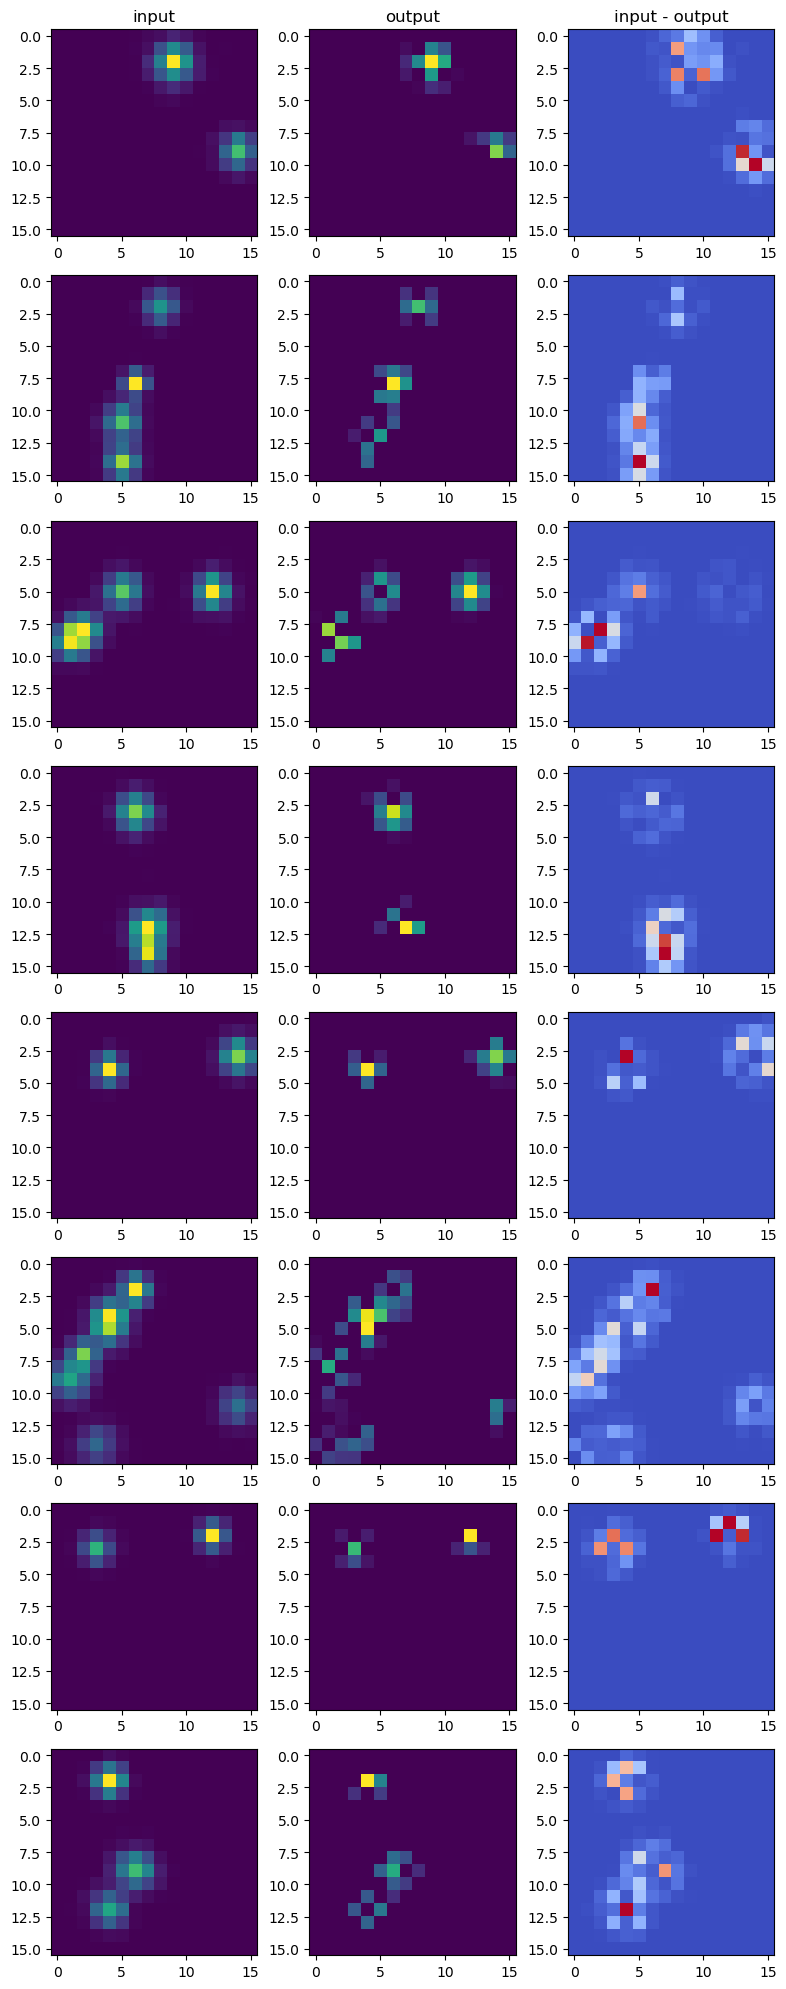

In [8]:
# compare images
with torch.no_grad():
    model.eval()
    
    fig, axes = plt.subplots(8, 3, facecolor='white', figsize=(8, 20))
    images, _ = iter(test_loader).next()
    images = images.to(device)
    images_pred = model(images)
    for ix, (image, image_pred) in enumerate(zip(images, images_pred)):
        image = image.cpu().numpy()
        image_pred = image_pred.cpu().numpy().reshape(image.shape)
        
        ax = axes[ix][0]
        ax.imshow(image)
        if ix == 0:
            ax.set_title('input')
        
        ax = axes[ix][1]
        ax.imshow(image_pred)
        if ix == 0:
            ax.set_title('output')
        
        ax = axes[ix][2]
        ax.imshow(abs(image - image_pred), cmap='coolwarm')
        if ix == 0:
            ax.set_title('input - output')
            
        #plt.colorbar()
        
        if ix == 9: break

    plt.tight_layout()
    plt.show()